# Cortex
This notebook plots the weights and activations  of  different LISSOM  layers:

- *Cortex:* a generic class, to represent an afferent, excitatory or inhibitory layer.
- *LGN:* a LGN layer. 
- *Lissom:* It is composed of Cortex layers and the LGN.
- *ReducedLissom:* A ReducedLissom is just a  Lissom  network  without  the  LGN layer.

In [40]:
from pylissom.nn.modules.lissom import *
from pylissom.nn.modules import register_recursive_input_output_hook
from pylissom.utils.plotting import *
from pylissom.utils.stimuli import gaussian_generator

import matplotlib.pyplot as plt

## Inspecting layer’s weights

Here, we build a cortex layer of V1 of dimension 5x5. This layer receive its input from an input layer of dimension 25x25. Each cortex neuron in V1 will have a receptive field of radius 5. The connection weights are initialized with a Gaussian function of $\sigma = 5$.

In [2]:
in_features = 25**2
out_features = 5**2
cortex = Cortex(in_features, out_features, radius=5, sigma=5)

Next, we plot in grayscale the layer's initial weights in V1 using the plot_layer_weights helper function.

As the dimension of V1 is 5x5, there are 25 neurons in V1. The plot shows the initial weights for each of these neurons, in a 5x5 array. Each neuron has 25x25 square plot, representing the retina. The weights are seen as clouds of white dots. As each neuron has a receptive field of radius 5, circular white plots of radius 5 are observed in the figure. However, most of the 25x25 weights of each neuron are equal to zero because they are outside the receptive field of the neuron, which explains the plot’s darkness

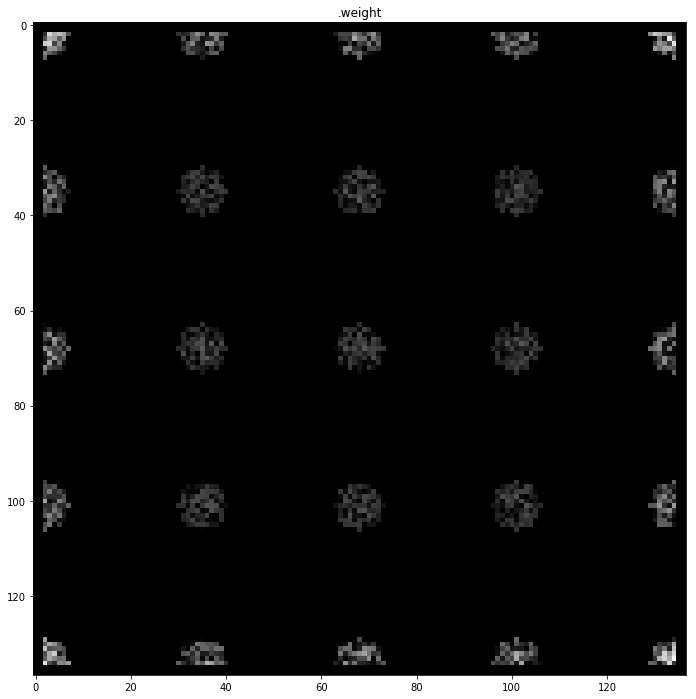

In [3]:
plt.figure(figsize=(12, 12))
plot_layer_weights(cortex, use_range=False)

To make this more clear, now we plot a *pylissom.nn.linear.GaussianCloud* layer that has the same initial weights as the V1 cortex but without the receptive field limitation. As we can see, the white dots clouds are larger and brighter than the ones in  the previous figure. The clouds are larger, because there is not the receptive field limitation. The clouds are brighter because there is not the normalization process that is done in the Cortex layer. Each weight in the GaussianCloud layer can have values between 0 and 1 but for a Cortex neuron, the sum of all weights must equal 1, so most weights have very small values, decaying proportionally to the size of the receptive field, hence the darkness.

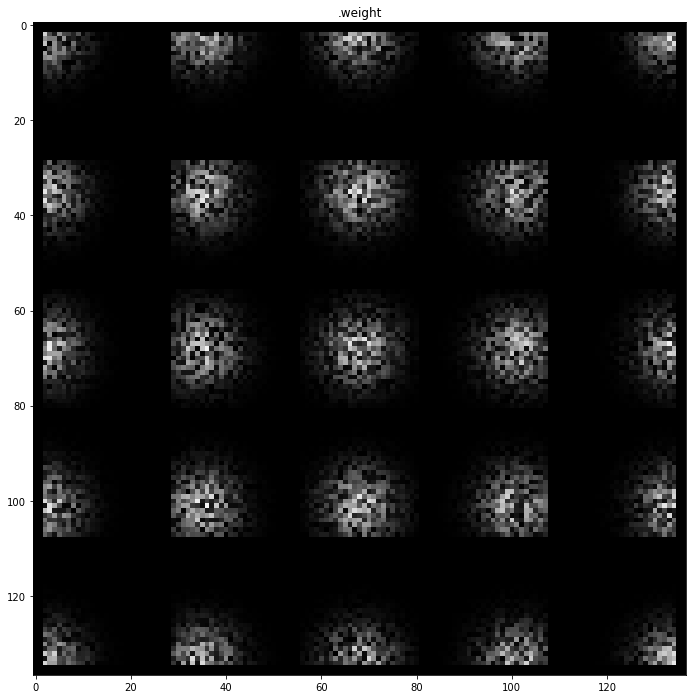

In [4]:
gaussian_linear = GaussianCloudLinear(in_features, out_features, sigma=5)
plt.figure(figsize=(12, 12))
plot_layer_weights(gaussian_linear)

# DiffOfGaussians

In [5]:
in_features = 25**2
out_features = 5**2
dofg = DifferenceOfGaussiansLinear(in_features, out_features, radius=5, on=False, sigma_surround=5, sigma_center=1)

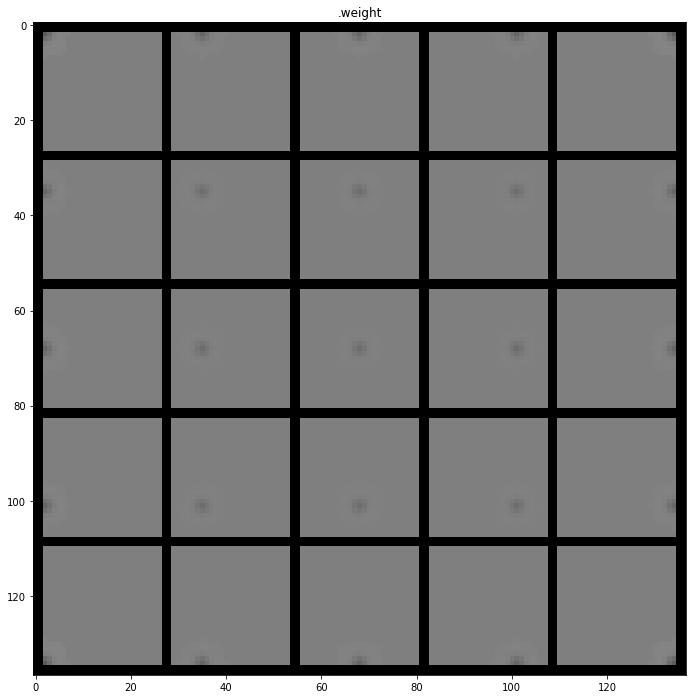

In [6]:
plt.figure(figsize=(12, 12))
plot_layer_weights(dofg, use_range=True)

In [7]:
in_features = 24**2
out_features = 5**2
unnorm_dofg = UnnormalizedDifferenceOfGaussiansLinear(in_features, out_features, on=False, sigma_surround=5, sigma_center=1)

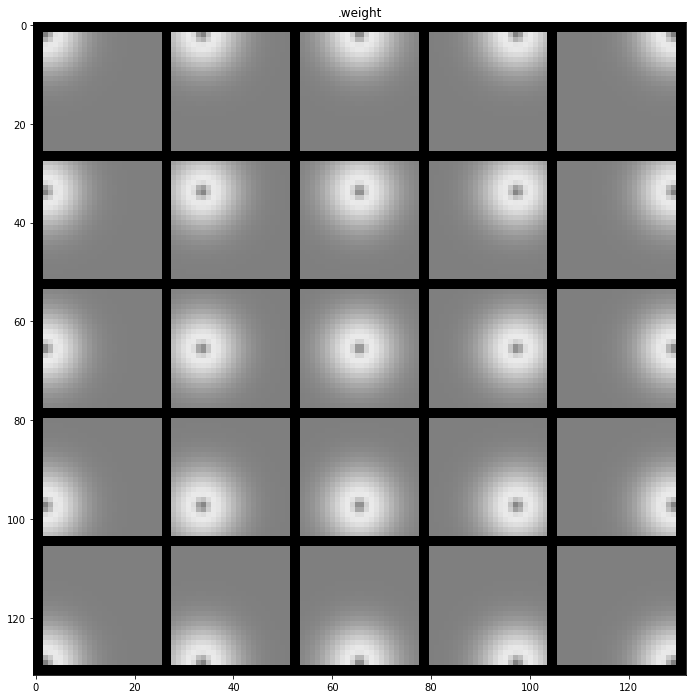

In [8]:
plt.figure(figsize=(12, 12))
plot_layer_weights(unnorm_dofg, use_range=True)

# LGN

In [9]:
retinal_density = 36
lgn_density = 36
radius_afferent = (lgn_density / 4 + 0.5)
scale_afferent = radius_afferent / 6.5  # radius_afferent_reference
radius_center_gaussian = 0.5*scale_afferent*retinal_density/lgn_density
radius_surround_gaussian = 4*radius_center_gaussian
radius_afferent_lgn = 4.7*radius_surround_gaussian

In [10]:
radius_center_gaussian

0.7307692307692307

In [11]:
radius_surround_gaussian

2.923076923076923

In [12]:
radius_afferent_lgn

13.738461538461538

In [13]:
in_features = retinal_density **2
out_features = lgn_density**2
off_test = LGN(in_features, out_features, 
          on=False, 
          radius=radius_afferent_lgn, 
                    sigma_surround=5, sigma_center=2)
on_test = LGN(in_features, out_features, 
          on=True, 
          radius=radius_afferent_lgn, 
          sigma_surround=radius_surround_gaussian, sigma_center=radius_center_gaussian)

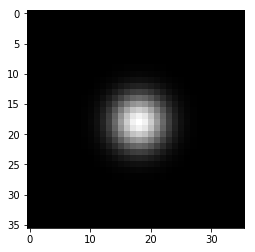

In [14]:
gauss_size = int(in_features**0.5)
sigma_x = 3
sigma_y = sigma_x
gauss = gaussian_generator(gauss_size, gauss_size//2, gauss_size//2, sigma_x, sigma_y, 0)
plot_matrix(gauss)
inp = torch.autograd.Variable(torch.from_numpy(gauss).view(in_features)).unsqueeze(0)

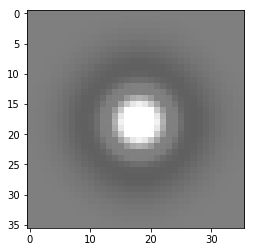

In [15]:
out_rows = int(out_features**0.5)
out = (on_test(inp) - off_test(inp)).data*2.33/1
mat = tensor_to_numpy_matrix(out, (out_rows,out_rows))
plt.imshow(mat, cmap='gray', vmin=-0.5, vmax=0.5)
plt.show()

##  Inspecting a layer’s activation: ReducedLissom

For this example, we will use a *pylissom.nn.lissom.ReducedLissom* layer to inspect the activation of its neurons. A ReducedLissom is a LISSOM network but without the LGN. A composition approach was used for complex layers such as ReducedLissom, so the parameters, in this case, are the afferent, excitatory and inhibitory modules (which are Cortex layers) already initialized, and also the strength factors, the settling steps and the $\theta$ threshold values for the Piecewise Sigmoid activation function.

In essence this ReducedLissom layer implements the activation function of Lissom, and abstracts itself from the creation of the inner cortex layers. 

The V1 layer, has a 36x36 dimension. The retina layer has also 36x36 dimension. Other parameters needed to build the ReducedLissom are listed below:

In [16]:
retinal_density = 36
lgn_density = retinal_density
cortical_density = 36
# Receptive Fields
radius_afferent = (lgn_density / 4 + 0.5)
radius_excitatory = (cortical_density / 10)
radius_inhibitory = cortical_density / 4 - 1
radius_gaussian_afferent = radius_afferent / 1.3
radius_gaussian_excitatory = 0.78 * radius_excitatory
radius_gaussian_inhibitory = 2.08 * radius_inhibitory
# Activation
settling_steps = 9
min_theta = 0.083
max_theta = min_theta + 0.55
# Scaling
afferent_factor = 1.0
excitatory_factor = 0.9
inhibitory_factor = 0.9

In [17]:
in_features = lgn_density**2
out_features = cortical_density**2
excitatory_map = Cortex(in_features, out_features, radius=radius_excitatory, sigma=radius_gaussian_excitatory)

In [18]:
in_features = cortical_density**2
out_features = cortical_density**2
afferent_map = Cortex(in_features, out_features, radius=radius_afferent, sigma=radius_gaussian_afferent)

In [19]:
in_features = cortical_density**2
out_features = cortical_density**2
inhibitory_map = Cortex(in_features, out_features, radius=radius_inhibitory, sigma=radius_gaussian_inhibitory)

Here, we build ReducedLissom:

In [20]:
v1 = ReducedLissom(afferent_module=afferent_map, excitatory_module=excitatory_map, inhibitory_module=inhibitory_map, 
                   min_theta=min_theta, max_theta=max_theta, settling_steps=settling_steps,
                  inhibitory_strength=inhibitory_factor, afferent_strength=afferent_factor, 
                   excitatory_strength=excitatory_factor)

The different internal parameters of ReducedLissom are displayed:

In [21]:
print(repr(v1))

ReducedLissom (
  (inhibitory_module): Cortex (1296 -> 1296, sigma=16.64, radius=8.0)
  (excitatory_module): Cortex (1296 -> 1296, sigma=2.8080000000000003, radius=3.6)
  (afferent_module): Cortex (1296 -> 1296, sigma=7.3076923076923075, radius=9.5)
  (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
, 1296 -> 1296, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)


In [41]:
register_recursive_input_output_hook(v1)

Here we create a gaussian input stimuli using the gaussian_generator helper function, that must match the retina size:

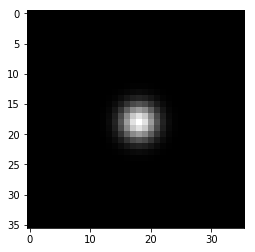

In [42]:
gauss_size = int(in_features**0.5)
gauss = gaussian_generator(gauss_size, gauss_size//2, gauss_size//2, 2, 2, 0)
plot_matrix(gauss)

Now we transform the numpy array to a pytorch Variable and resize it to match the 1-dimensional shape that pytorch layers expect as input. 

In [43]:
inp = torch.autograd.Variable(torch.from_numpy(gauss).view(in_features)).unsqueeze(0)

A plot of the ReducedLissom activation for the gaussian stimulus is displayed below. Note that the activations for all the neurons in the V1 layer are displayed, because the V1 has a 36x36 dimension. 

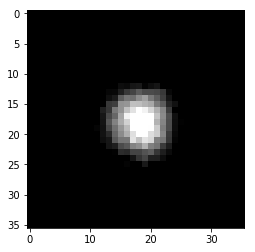

In [44]:
out_rows = int(out_features**0.5)
plot_tensor(v1(inp*2.33).data, (out_rows,out_rows))

Below we plot the input and activation for the different modules that contribute to the activation of a V1 neuron:

- v1.inhibitory_module.input: input at time (t-1) for the inhibitory connections. These are the activations of the V1 neurons at time (t-1).
- v1.inhibitory_module.activation: these is the product of the input at time (t-1) and the inhibitory weights.
- v1.excitatory_module.input: input at time (t-1) for the excitatory connections. These are the activations of the V1 neurons at time (t-1). Note that this is the same figure than the top figure, because the input is the activation of the V1 neurons at time (t-1).
- v1.excitatory_module.activation: these is the product of the input at time (t-1) and the excitatory weights.
- v1.afferent_module.input: input at the retina.
- v1.afferent_module.activation: these is the product of the input at the retina and the afferent weights.
- v1.input: input at the retina.
- v1.activation: final activation of the V1 layer at time t.

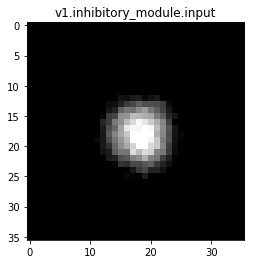

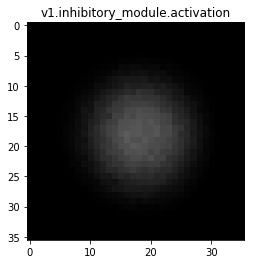

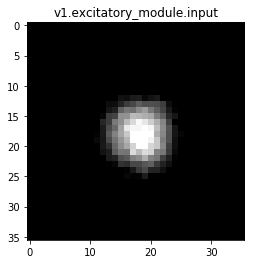

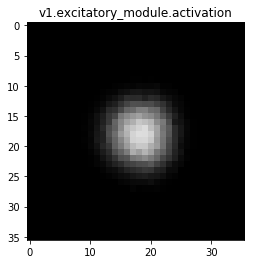

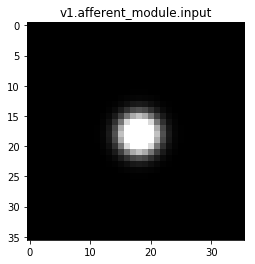

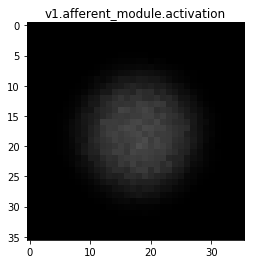

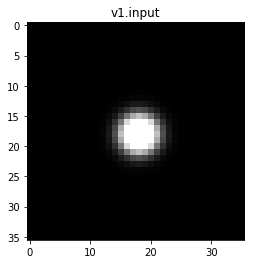

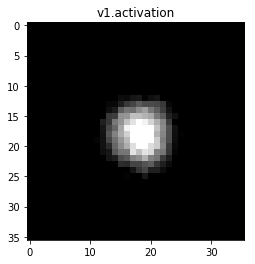

In [45]:
plot_layer_activation(v1, 'v1')

# Lissom

In [46]:
retinal_density = 36
lgn_density = 36
cortical_density = 36
# Receptive Fields
radius_afferent = (lgn_density / 4 + 0.5)
radius_excitatory = (cortical_density / 10)
radius_inhibitory = cortical_density / 4 - 1
radius_gaussian_afferent = radius_afferent / 1.3
radius_gaussian_excitatory = 0.78 * radius_excitatory
radius_gaussian_inhibitory = 2.08 * radius_inhibitory
# LGN
scale_afferent = radius_afferent / 6.5  # radius_afferent_reference
radius_center_gaussian = 0.5*scale_afferent*retinal_density/lgn_density
radius_surround_gaussian = 4*radius_center_gaussian
radius_afferent_lgn = 4.7*radius_surround_gaussian
# Activation
settling_steps = 9
min_theta = 0.083
max_theta = min_theta + 0.55
# Scaling
afferent_factor = 1.0
excitatory_factor = 0.9
inhibitory_factor = 0.9
lgn_factor = 2.33 / 1 #  (brightness scale of the retina, contrast of fully bright stimulus)

In [47]:
in_features = lgn_density**2
out_features = cortical_density**2
excitatory_map = Cortex(in_features, out_features, radius=radius_excitatory, sigma=radius_gaussian_excitatory)

In [48]:
in_features = cortical_density**2
out_features = cortical_density**2
afferent_map = Cortex(in_features, out_features, radius=radius_afferent, sigma=radius_gaussian_afferent)

In [49]:
in_features = cortical_density**2
out_features = cortical_density**2
inhibitory_map = Cortex(in_features, out_features, radius=radius_inhibitory, sigma=radius_gaussian_inhibitory)

In [50]:
v1 = ReducedLissom(afferent_module=afferent_map, excitatory_module=excitatory_map, inhibitory_module=inhibitory_map, 
                   min_theta=min_theta, max_theta=max_theta, settling_steps=settling_steps,
                  inhibitory_strength=inhibitory_factor, afferent_strength=afferent_factor, 
                   excitatory_strength=excitatory_factor)

In [51]:
in_features = retinal_density **2
out_features = lgn_density**2
off = LGN(in_features, out_features, 
          on=False, 
          radius=radius_afferent_lgn, 
                    sigma_surround=radius_surround_gaussian, sigma_center=radius_center_gaussian,
         strength=lgn_factor)
on = LGN(in_features, out_features, 
          on=True, 
          radius=radius_afferent_lgn, 
          sigma_surround=radius_surround_gaussian, sigma_center=radius_center_gaussian,
        strength=lgn_factor)

In [52]:
lissom = Lissom(on=on, off=off, v1=v1)

In [53]:
print(repr(lissom))

Lissom (
  (v1): ReducedLissom (
    (inhibitory_module): Cortex (1296 -> 1296, sigma=16.64, radius=8.0)
    (excitatory_module): Cortex (1296 -> 1296, sigma=2.8080000000000003, radius=3.6)
    (afferent_module): Cortex (1296 -> 1296, sigma=7.3076923076923075, radius=9.5)
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
  , 1296 -> 1296, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)
  (off): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (1296 -> 1296, sigma_surround=2.923076923076923, sigma_center=0.7307692307692307, radius=13.738461538461538, on=False)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
  (on): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (1296 -> 1296, sigma_surround=2.923076923076923, sigma_center=0.7307692307692307, radius=13.738461538461538, on=True)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_t

In [54]:
register_recursive_forward_hook(lissom, input_output_hook)

NameError: name 'input_output_hook' is not defined

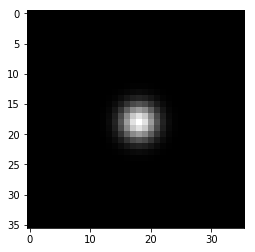

In [55]:
gauss_size = int(in_features**0.5)
gauss = gaussian_generator(gauss_size, gauss_size//2, gauss_size//2, 2, 2, 0)
plot_matrix(gauss)

In [56]:
inp = torch.autograd.Variable(torch.from_numpy(gauss).view(in_features)).unsqueeze(0)

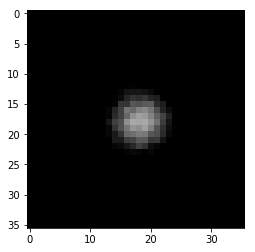

In [57]:
out_rows = int(out_features**0.5)
plot_tensor(lissom(inp).data, (out_rows,out_rows))

In [58]:
plot_layer_activation(lissom, 'lissom')

# Playground